In [82]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm

import functions as fn

In [83]:
aqi_df = pd.read_csv("./monthly_aqi_data.csv")
aqi_df.head()

,district,month,aqi,year
0,Nizamabad,Jan,61.333333333333336,2017
1,Nizamabad,Feb,61.55555555555556,2017
2,Nizamabad,Mar,63.22222222222222,2017
3,Nizamabad,Apr,67.37037037037038,2017
4,Nizamabad,May,68.40740740740742,2017


In [84]:
aaq_df = pd.read_csv("./monthly_aaq_data.csv")
aaq_df.head()

,district,month,SO2,NOx,PM10,PM2.5,NH3,year
0,Khammam,Jan,6.0,19.0,46.0,NaN,NaN,2016
1,Khammam,Feb,7.0,19.0,51.0,NaN,NaN,2016
2,Khammam,Mar,6.1,20.7,54.0,NaN,NaN,2016
3,Khammam,Apr,8.0,19.0,51.0,NaN,NaN,2016
4,Khammam,May,7.0,19.0,47.0,NaN,NaN,2016


### Nizamabad

We'll be trying out 3 models to forecast AQI
1. ARIMA on AQI
2. ARIMAX on AQI with SO2, NOx and PM10 as exogenous variables
3. VARMAX on AQI, SO2, NOx and PM10.

The model giving the best result will be used for all other districts.

In [85]:
df = fn.combine_aqi_aaq(aqi_df=aqi_df, aaq_df=aaq_df, district="Nizamabad")
df.head()

,district,aqi,date,SO2,NOx,PM10
0,Nizamabad,61.333333,2017-01-01,5.0,20.0,61.0
1,Nizamabad,61.555556,2017-02-01,5.0,20.0,62.0
2,Nizamabad,63.222222,2017-03-01,5.0,21.0,63.0
3,Nizamabad,67.370370,2017-04-01,5.0,20.0,67.0
4,Nizamabad,68.407407,2017-05-01,5.0,20.0,68.0


In [86]:
df.set_index("date", inplace=True)

<AxesSubplot:xlabel='date'>

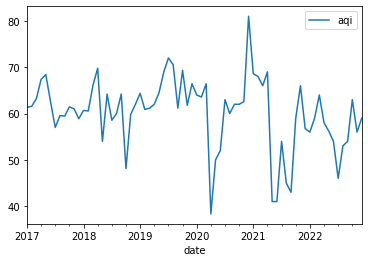

In [87]:
df.plot(y='aqi')

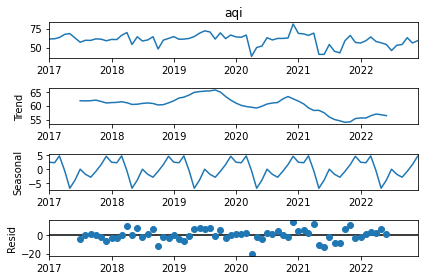

In [186]:
# seasonal decomposition
seasonal_decomp = sm.tsa.seasonal_decompose(df['aqi'], model='additive')
seasonal_decomp.plot()
plt.show()

##### ARIMA Model

Applying Augmented Dickey Fuller(ADF) test to check for stationarity.

In [88]:
def print_adf_results(adf_result: pd.DataFrame) -> None:
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))


In [89]:
from statsmodels.tsa.stattools import adfuller

print_adf_results(adfuller(df['aqi']))

ADF Statistic: -5.128786
p-value: 0.000012
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


ADF statistic value is less than 5% critical value and p<0.05. So the time series is stationary.

In [221]:
# auto arima to find the right parameters
params = pm.auto_arima(
    y=df['aqi'],
    start_p=1, start_q=1, m=12,
    test='adf',
    trace=True, error_action='ignore',
    supress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=493.646, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=500.399, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=488.409, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=492.001, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=797.494, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=486.496, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=488.396, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=490.394, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=488.122, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=488.196, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=490.012, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=490.107, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.190 seconds


In [226]:
arima_model = sm.tsa.arima.ARIMA(df['aqi'], order=(5, 1, 0))
arima = arima_model.fit()
arima.summary()

c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    aqi   No. Observations:                   72
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -242.590
Date:                Sat, 04 Mar 2023   AIC                            497.180
Time:                        20:01:16   BIC                            510.756
Sample:                    01-01-2017   HQIC                           502.579
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4212      0.137     -3.068      0.002      -0.690      -0.152
ar.L2         -0.2592      0.208     -1.248      0.212      -0.666       0.148
ar.L3         -0.1209      0.155     -0.782      0.434      -0.424       0.182
ar.L4         -0.0098      0.194     -0.051      0.960      -0.390       0.371
ar.L5         -0.0138      0.111     -0.124      0.902      -0.232       0.205
sigma2        54.1728      5.635      9.614      0.000      43.129      65.217
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                62.36
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                            -1.18
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

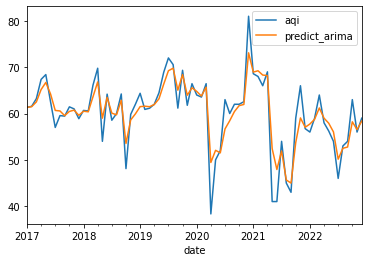

In [227]:
df['predict_arima'] = list(arima.predict(1, len(df)))
df[['aqi', 'predict_arima']].plot()

<AxesSubplot:>

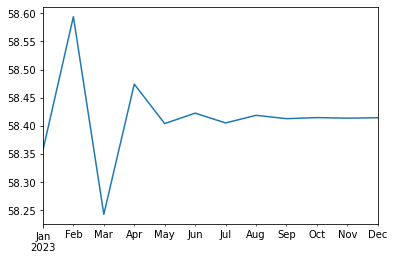

In [228]:
arima.forecast(12).plot()

In [229]:
sm.stats.acorr_ljungbox(arima.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,6.292563,0.790114


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


def evaluate(pred_df, org_df):
    mae = mean_absolute_error(pred_df, org_df)
    rmse = sqrt(mean_squared_error(pred_df, org_df))
    print("MAE: ", mae)
    print("RMSE: ", rmse)


In [ ]:
evaluate(df['predict_arima'], df['aqi'])

MAE:  2.112358268363385
RMSE:  3.1713954394887884


##### ARIMAX Model

In [101]:
params = pm.auto_arima(
    y=df['aqi'], X=df[['SO2', 'NOx', 'PM10']],
    start_p=1, start_q=1, m=12,
    test='adf',
    trace=True, error_action = 'ignore',
    supress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=449.263, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=441.338, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=440.909, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=447.584, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=439.271, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=440.934, Time=0.23 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=440.925, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=440.953, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=439.536, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=442.927, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=437.547, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[12]             : AIC=439.355, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12]             : AI

In [103]:
arimax_model = pm.ARIMA(order=(0,0,1))
arimax = arimax_model.fit(y = df['aqi'], X=df[['SO2', 'NOx', 'PM10']], )
arimax.summary()

c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -213.636
Date:                Thu, 02 Mar 2023   AIC                            439.271
Time:                        23:41:36   BIC                            452.931
Sample:                    01-01-2017   HQIC                           444.709
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.5223     19.786     -0.178      0.859     -42.303      35.259
SO2           -0.7699      2.539     -0.303      0.762      -5.746       4.206
NOx            0.4977      0.621      0.801      0.423      -0.720       1.715
PM10           0.9394      0.134      7.002      0.000       0.676       1.202
ma.L1          0.4126      0.141      2.919      0.004       0.136       0.690
sigma2        22.4556      2.847      7.886      0.000      16.875      28.036
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1098.21
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               6.89   Skew:                            -3.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
df['predict_arimax'] = list(arimax.predict_in_sample(start=1, end=len(df), X=df[['SO2', 'NOx', 'PM10']]))
df[['aqi', 'predict_arimax']].plot()

ValueError: Provided exogenous values are not of the appropriate shape. Required (1, 3), got (72, 3).

### VARMAX

In [136]:
from numpy.linalg import LinAlgError
def find_params():
    test_results = {}

    for p in range(5):
        for q in range(5):
            if p == 0 and q == 0:
                continue

            print(f'Testing Order: p = {p}, q = {q}')
            convergence_error = stationarity_error = 0

            try:
                model = sm.tsa.VARMAX(df[['aqi', 'SO2', 'NOx', 'PM10']], order=(p, q), trend='n')
                model_result = model.fit(maxiter=1000, disp=False)

            except LinAlgError:
                convergence_error += 1

            except ValueError:
                stationarity_error += 1

            print('\nAIC:', model_result.aic)
            print('BIC:', model_result.bic)
            print('HQIC:', model_result.hqic)
            print('------------------------')

            test_results[(p, q)] = [model_result.aic,
                                    model_result.bic,
                                    convergence_error,
                                    stationarity_error]


In [137]:
find_params()

Testing Order: p = 0, q = 1


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1614.6350696972172
BIC: 1673.8283887916346
HQIC: 1638.2001053162223
------------------------
Testing Order: p = 0, q = 2


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1625.6225824577084
BIC: 1721.2425594563827
HQIC: 1663.6891784576399
------------------------
Testing Order: p = 0, q = 3


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1650.7683675916646
BIC: 1782.8150024945958
HQIC: 1703.3365239725222
------------------------
Testing Order: p = 0, q = 4


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1571.6462468254801
BIC: 1740.1195396326682
HQIC: 1638.715963587264
------------------------
Testing Order: p = 1, q = 0


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1282.5179514728475
BIC: 1341.7112705672648
HQIC: 1306.0829870918526
------------------------
Testing Order: p = 1, q = 1


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\


AIC: 1267.6190925392207
BIC: 1363.239069537895
HQIC: 1305.6856885391521
------------------------
Testing Order: p = 1, q = 2


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1275.5462952255625
BIC: 1407.5929301284937
HQIC: 1328.11445160642
------------------------
Testing Order: p = 1, q = 3


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1297.787110624451
BIC: 1466.2604034316391
HQIC: 1364.856827386235
------------------------
Testing Order: p = 1, q = 4


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1304.8062415877273
BIC: 1509.7061922991722
HQIC: 1386.3775187304375
------------------------
Testing Order: p = 2, q = 0


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1285.6528914518462
BIC: 1381.2728684505205
HQIC: 1323.7194874517777
------------------------
Testing Order: p = 2, q = 1


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\


AIC: 1273.1283801015347
BIC: 1405.1750150044659
HQIC: 1325.6965364823923
------------------------
Testing Order: p = 2, q = 2


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1269.0721902106025
BIC: 1437.5454830177905
HQIC: 1336.1419069723863
------------------------
Testing Order: p = 2, q = 3


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1296.9304005831286
BIC: 1501.8303512945736
HQIC: 1378.5016777258388
------------------------
Testing Order: p = 2, q = 4


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1302.920628204026
BIC: 1544.2472368197277
HQIC: 1398.9934657276622
------------------------
Testing Order: p = 3, q = 0


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1299.8273195267668
BIC: 1431.873954429698
HQIC: 1352.3954759076244
------------------------
Testing Order: p = 3, q = 1


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



AIC: 1296.2775784924522
BIC: 1464.7508712996403
HQIC: 1363.347295254236
------------------------
Testing Order: p = 3, q = 2


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1299.9957405369341
BIC: 1504.895691248379
HQIC: 1381.5670176796443
------------------------
Testing Order: p = 3, q = 3


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1326.1586838362618
BIC: 1567.4852924519637
HQIC: 1422.2315213598981
------------------------
Testing Order: p = 3, q = 4


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1336.9866108052522
BIC: 1614.739877325211
HQIC: 1447.5610087098148
------------------------
Testing Order: p = 4, q = 0


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\stat


AIC: 1312.7349072558995
BIC: 1481.2082000630876
HQIC: 1379.8046240176834
------------------------
Testing Order: p = 4, q = 1


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1304.3012915358415
BIC: 1509.2012422472865
HQIC: 1385.8725686785517
------------------------
Testing Order: p = 4, q = 2


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1330.4791374157357
BIC: 1571.8057460314376
HQIC: 1426.551974939372
------------------------
Testing Order: p = 4, q = 3


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1327.7412969627558
BIC: 1605.4945634827145
HQIC: 1438.3156948673184
------------------------
Testing Order: p = 4, q = 4


c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 1380.5645088353858
BIC: 1694.7444332596015
HQIC: 1505.6404671208747
------------------------


In [148]:
varmax = sm.tsa.VARMAX(df[['aqi','SO2', 'NOx', 'PM10']], order=(1,2)).fit(maxiter=1000)
varmax.summary()

c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['aqi', 'SO2', 'NOx', 'PM10']",No. Observations:,72
Model:,"VARMA(1,2)",Log Likelihood,-578.063
,+ intercept,AIC,1280.126
Date:,"Fri, 03 Mar 2023",BIC,1421.280
Time:,10:48:29,HQIC,1336.320
Sample:,01-01-2017,,
,- 12-01-2022,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.52, 0.23, 0.01, 0.26",Jarque-Bera (JB):,"25.32, 1.51, 2.81, 2.93"
Prob(Q):,"0.47, 0.63, 0.92, 0.61",Prob(JB):,"0.00, 0.47, 0.25, 0.23"
Heteroskedasticity (H):,"2.60, 4.70, 2.20, 0.83",Skew:,"-0.94, 0.36, -0.45, -0.21"


<AxesSubplot:xlabel='date'>

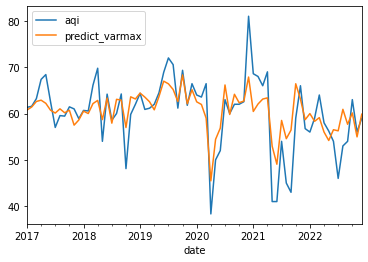

In [149]:
df['predict_varmax'] = list(varmax.predict(start=1, end=len(df))['aqi'])
df[['aqi', 'predict_varmax']].plot()

<AxesSubplot:>

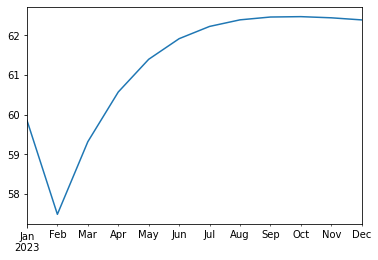

In [150]:
varmax.forecast(12)['aqi'].plot()

In [151]:
sm.stats.acorr_ljungbox(arima.resid, lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,6.292563,0.790114


In [152]:
evaluate(df['predict_varmax'], df['aqi'])

MAE:  3.5246617953479875
RMSE:  4.7967236682102445


### MLR - DO not use

In [ ]:
split = int(len(df) * 0.85)
# X = df[['SO2', 'NOx', 'PM10']]
# y = df['aqi']
df_train, df_test = df.iloc[:split], df.iloc[split:]
# X_train, X_test = X.iloc[:split], X.iloc[split:]
# y_train, y_test = y.iloc[:split], y.iloc[split:]


In [155]:
from sklearn import linear_model


lr = linear_model.LinearRegression()
lr.fit(df_train[['SO2','NOx', 'PM10']], df_train['aqi'])


LinearRegression()

C:\Users\ayush\AppData\Local\Temp/ipykernel_31644/4169335337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict_mlr'] = lr.predict(df_test[['SO2', 'NOx', 'PM10']])


<AxesSubplot:xlabel='date'>

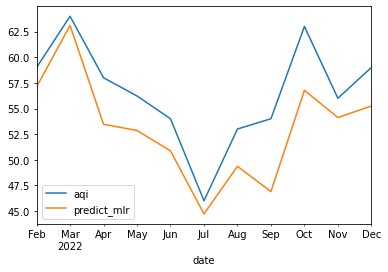

In [171]:
df_test['predict_mlr'] = lr.predict(df_test[['SO2', 'NOx', 'PM10']])

df_test[['aqi', 'predict_mlr']].plot()

In [172]:
evaluate(df_test['predict_mlr'], df_test['aqi'])

MAE:  3.4276123321752507
RMSE:  3.9057551403600907


### Holt Winter Model

In [507]:
holt_winter = sm.tsa.ExponentialSmoothing(df['aqi'], seasonal='add' ,seasonal_periods=12)
x = holt_winter.fit(smoothing_seasonal=0.1, use_brute=True)
x.params

c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.43148642186641106,
 'smoothing_trend': nan,
 'smoothing_seasonal': 0.1,
 'damping_trend': nan,
 'initial_level': 61.08540783457223,
 'initial_trend': nan,
 'initial_seasons': array([ 1.6224173 ,  1.17553908,  2.9715401 , -0.50545586, -4.9924536 ,
        -2.8863986 , -1.45917466, -1.50628557, -1.69878264,  0.94976517,
         1.44275655,  4.01478201]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<AxesSubplot:xlabel='date'>

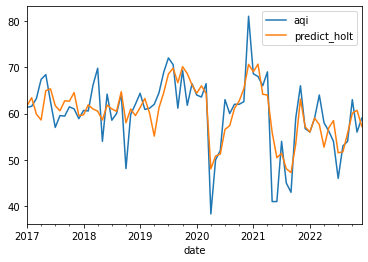

In [508]:
df['predict_holt'] = list(x.predict(1, len(df)))
df[['aqi', 'predict_holt']].plot()

<AxesSubplot:>

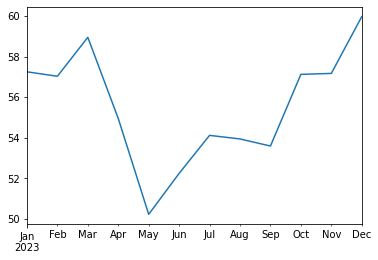

In [509]:
x.forecast(12).plot()


In [510]:
sm.stats.acorr_ljungbox(x.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,20.849347,0.022169


In [511]:
evaluate(df['predict_holt'], df['aqi'])

MAE:  3.3604045542574745
RMSE:  4.4831566960310365


### Individual ARIMA

#### ARIMA on SO2

In [512]:
params = pm.auto_arima(
    y=df['SO2'],
    start_p=1, start_q=1, m=12,
    test='adf',
    trace=True, error_action='ignore',
    supress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=122.844, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=126.902, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=127.197, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=124.487, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=125.168, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=120.848, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=118.864, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=120.847, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=122.488, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=125.305, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=120.612, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=120.696, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=119.567, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=124.899, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[12] intercep

In [513]:
so2_model = sm.tsa.arima.ARIMA(df['SO2'], order=(1, 1, 1))
so2_model = so2_model.fit()
so2_model.summary()

c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    SO2   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -56.454
Date:                Sat, 04 Mar 2023   AIC                            118.908
Time:                        20:56:56   BIC                            125.696
Sample:                    01-01-2017   HQIC                           121.607
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4251      0.164      2.592      0.010       0.104       0.747
ma.L1         -0.7838      0.116     -6.754      0.000      -1.011      -0.556
sigma2         0.2858      0.045      6.397      0.000       0.198       0.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.94   Prob(JB):                         0.68
Heteroskedasticity (H):               8.08   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

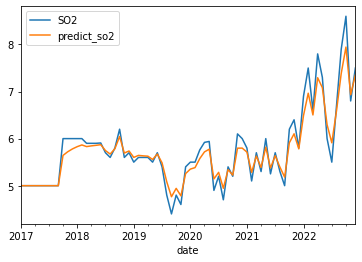

In [514]:
df['predict_so2'] = list(so2_model.predict(1, len(df)))
df[['SO2', 'predict_so2']].plot()

In [515]:
sm.stats.acorr_ljungbox(so2_model.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.129006,0.995252


#### ARIMA on NOx

In [516]:
params = pm.auto_arima(
    y=df['NOx'],
    start_p=1, start_q=1, m=12,
    test='adf',
    trace=True, error_action='ignore',
    supress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=252.346, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=262.054, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=261.812, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=254.147, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=260.097, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=250.485, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=250.456, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=250.365, Time=0.10 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=252.345, Time=0.32 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=254.345, Time=0.41 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=253.689, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=250.687, Time=0.16 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=251.286, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=263.196, Time=0.03 sec
 ARIMA(0,1,2)(1,0,0)[12] intercep

In [517]:
nox_model = sm.tsa.arima.ARIMA(df['NOx'], order=(0, 1, 2), seasonal_order=(1,0,0,12))
nox_model = nox_model.fit()
nox_model.summary()

c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               NOx   No. Observations:                   72
Model:             ARIMA(0, 1, 2)x(1, 0, [], 12)   Log Likelihood                -120.353
Date:                           Sat, 04 Mar 2023   AIC                            248.706
Time:                                   20:57:01   BIC                            257.757
Sample:                               01-01-2017   HQIC                           252.305
                                    - 12-01-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4555      0.126     -3.604      0.000      -0.703      -0.208
ma.L2         -0.2703      0.112     -2.402      0.016      -0.491      -0.050
ar.S.L12       0.2136      0.127      1.686      0.092      -0.035       0.462
sigma2         1.7087      0.270      6.326      0.000       1.179       2.238
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 5.50
Prob(Q):                              0.86   Prob(JB):                         0.06
Heteroskedasticity (H):               5.58   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

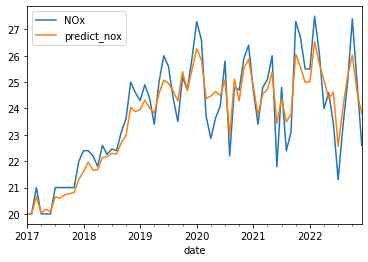

In [518]:
df['predict_nox'] = list(nox_model.predict(1, len(df)))
df[['NOx', 'predict_nox']].plot()

In [519]:
sm.stats.acorr_ljungbox(nox_model.resid, lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,0.74947,0.999955


#### ARIMA on PM10

In [520]:
params = pm.auto_arima(
    y=df['PM10'],
    start_p=1, start_q=1, m=12,
    test='adf',
    trace=True, error_action='ignore',
    supress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=461.685, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=458.274, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=451.183, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=459.685, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=450.103, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=451.079, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=452.910, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=456.286, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=447.869, Time=0.04 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=448.962, Time=0.09 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=448.971, Time=0.09 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=45

In [521]:
pm10_model = sm.tsa.arima.ARIMA(df['PM10'], order=(1, 1, 1), seasonal_order=(0,0,0,12))
pm10_model = pm10_model.fit()
pm10_model.summary()

c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   PM10   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -218.357
Date:                Sat, 04 Mar 2023   AIC                            442.713
Time:                        20:57:04   BIC                            449.501
Sample:                    01-01-2017   HQIC                           445.413
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3921      0.100      3.928      0.000       0.196       0.588
ma.L1         -0.9445      0.073    -12.853      0.000      -1.088      -0.800
sigma2        26.9052      3.208      8.387      0.000      20.618      33.193
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                20.82
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -1.04
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

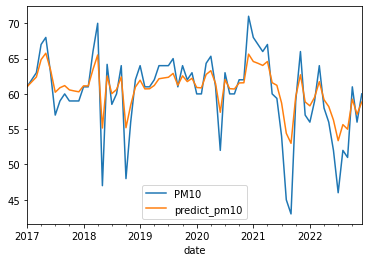

In [522]:
df['predict_pm10'] = list(pm10_model.predict(1, len(df)))
df[['PM10', 'predict_pm10']].plot()


In [523]:
sm.stats.acorr_ljungbox(nox_model.resid, lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,0.74947,0.999955


In [524]:
def aqi(so2, nox, pm10):
    so2_aqi = (200-101)/(800-301) * (so2 - 301) + 101
    nox_aqi = (200-101)/(400-201) * (nox - 201) + 101
    pm10_aqi = (200-101)/(500-351) * (pm10 - 351) + 101

    return max(so2_aqi, pm10_aqi, nox_aqi)

In [525]:
temp = df.apply(lambda row: aqi(row['predict_so2'], row['predict_nox'], row['predict_pm10']), axis=1)